# Analysis of action potential waveforms

This notebook applies a pacing protocol to the Nygren and Courtemanche action potential models and compares the action potentials and major ion currents in after the final stimulation.

In [1]:
import myokit
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline

In [3]:
nyg = myokit.load_model('models/nygren.mmt')
cou = myokit.load_model('models/courtemanche.mmt')

The models have different membrane capacitance values so we apply a different stimulus current in either case to get the same value in pA/pF.

In [4]:
Cm_nyg = nyg.get('membrane.Cm').value()*1e3 # pF
Cm_cou = cou.get('membrane.Cm').value()     # pF

#### Courtemanche

In [5]:
# 2 Hz pacing protocol
npulses = 1000
period = 1000 # ms
duration = 1 # ms
level = -4000 # pA => -4000/100 = -40 pA/pF
offset = 1000 # ms

pulsetrain_cou = myokit.pacing.blocktrain(period, duration, offset=offset, level=level, limit=npulses)

In [6]:
pace = cou.get('membrane.i_st')
if pace.binding() != 'pace':
    if pace.is_state():
        pace.demote()
    pace.set_rhs(0)
    pace.set_binding('pace')

In [7]:
cou_sim = myokit.Simulation(cou, pulsetrain_cou)

In [8]:
data_cou = cou_sim.run(pulsetrain_cou.characteristic_time())
# Get only the last pulse
data_cou = data_cou.trim((npulses-1)*period+offset, (npulses-1)*period+offset+400, adjust=True)

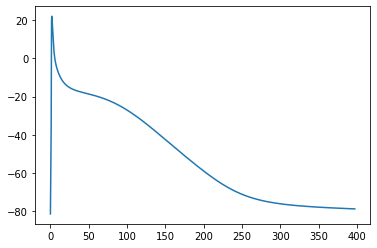

In [10]:
plt.plot(data_cou['environment.time'], data_cou['membrane.V'])

#### Nygren

In [11]:
# 2 Hz pacing protocol
npulses = 1000
period = 1 # s
duration = 1e-3 # s
level = -2000 # pA -> -2000/50 = -40 pA/pF
offset = 1 # s

pulsetrain_nyg = myokit.pacing.blocktrain(period, duration, offset=offset, level=level, limit=npulses)

In [13]:
pace = nyg.get('membrane.i_Stim')
if pace.binding() != 'pace':
    if pace.is_state():
        pace.demote()
    pace.set_rhs(0)
    pace.set_binding('pace')
nyg_sim = myokit.Simulation(nyg, pulsetrain_nyg)

In [14]:
data_nyg = nyg_sim.run(pulsetrain_nyg.characteristic_time())
data_nyg = data_nyg.trim((npulses-1)*period+offset, (npulses-1)*period+offset+0.4, adjust=True)

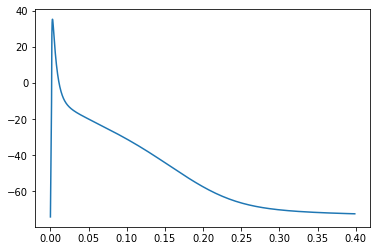

In [15]:
plt.plot(data_nyg['environment.time'], data_nyg['membrane.V'])

#### Comparison

In [16]:
data_cou_ina = data_cou.trim_right(5)
data_nyg_ina = data_nyg.trim_right(5e-3)
data_cou_ical = data_cou.trim_right(20)
data_nyg_ical = data_nyg.trim_right(20e-3)
data_cou_ik = data_cou.trim_right(15)
data_nyg_ik = data_nyg.trim_right(15e-3)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


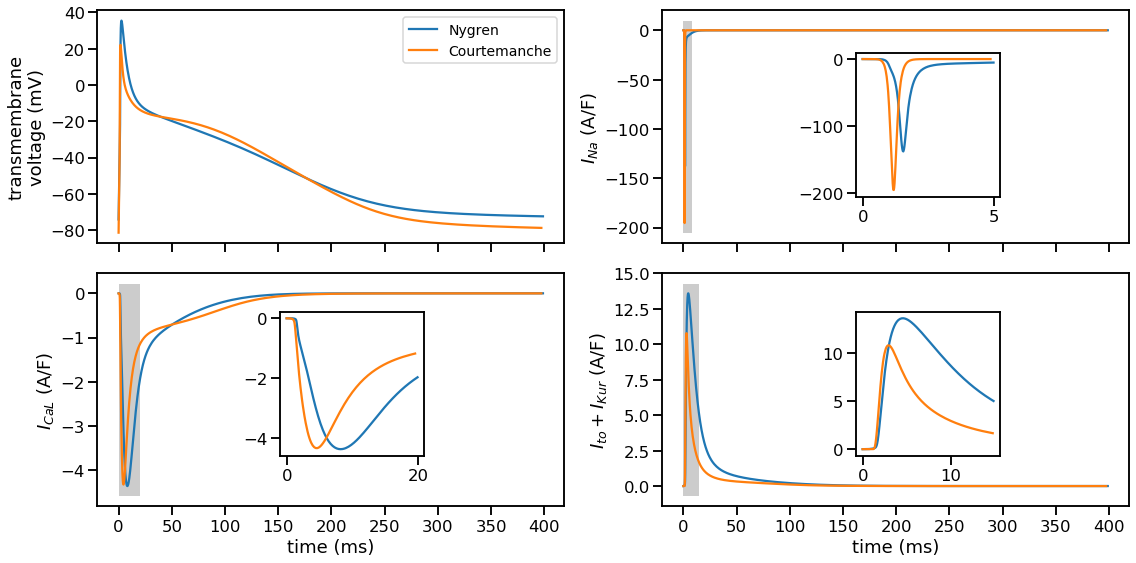

In [17]:
sns.set_context('talk')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

fig, ax = plt.subplots(ncols=2, nrows=2, sharex=True, figsize=(16, 8))
ax = ax.flatten()

# Action potential
ax[0].plot(np.array(data_nyg['environment.time'])*1000, data_nyg['membrane.V'], label='Nygren')
ax[0].plot(data_cou['environment.time'], data_cou['membrane.V'], label='Courtemanche')
ax[0].legend(loc='upper right')

# Sodium current
ax[1].plot(np.array(data_nyg['environment.time'])*1000, 
           np.array(data_nyg['sodium_current.i_Na'])/Cm_nyg)
ax[1].plot(data_cou['environment.time'], 
           np.array(data_cou['fast_sodium_current.i_Na'])/Cm_cou)
ax[1].fill_between([0., 8.], ax[1].get_ylim()[0], ax[1].get_ylim()[1],
                   facecolor='k', alpha=0.2)

ax_ina = plt.axes([.75, .65, .125, .2*1.25])
plt.plot(np.array(data_nyg_ina['environment.time'])*1000, 
         np.array(data_nyg_ina['sodium_current.i_Na'])/Cm_nyg)
plt.plot(data_cou_ina['environment.time'],
         np.array(data_cou_ina['fast_sodium_current.i_Na'])/Cm_cou)
ax_ina.set_xlabel('')
ax_ina.set_ylabel('')

# Calcium current
ax[2].plot(np.array(data_nyg['environment.time'])*1000, 
           np.array(data_nyg['L_type_Ca_channel.i_Ca_L'])/Cm_nyg)
ax[2].plot(data_cou['environment.time'], 
           np.array(data_cou['L_type_Ca_channel.i_Ca_L'])/Cm_cou)
ax[2].fill_between([0., 20.], ax[2].get_ylim()[0], ax[2].get_ylim()[1],
                   facecolor='k', alpha=0.2)

ax_ical = plt.axes([.25, .2, .125, .2*1.25])
plt.plot(np.array(data_nyg_ical['environment.time'])*1000, 
         np.array(data_nyg_ical['L_type_Ca_channel.i_Ca_L'])/Cm_nyg)
plt.plot(data_cou_ical['environment.time'],
         np.array(data_cou_ical['L_type_Ca_channel.i_Ca_L'])/Cm_cou)
ax_ical.set_xlabel('')
ax_ical.set_ylabel('')

# Potassium currents
ax[3].plot(np.array(data_nyg['environment.time'])*1000, 
           (np.array(data_nyg['Ca_independent_transient_outward_K_current.i_t'])+
           np.array(data_nyg['sustained_outward_K_current.i_sus']))/Cm_nyg)
ax[3].plot(data_cou['environment.time'], 
           (np.array(data_cou['transient_outward_K_current.i_to'])+
           np.array(data_cou['ultrarapid_delayed_rectifier_K_current.i_Kur']))/Cm_cou)
ax[3].fill_between([0., 15.], ax[3].get_ylim()[0], ax[3].get_ylim()[1],
                   facecolor='k', alpha=0.2)

ax_ik = plt.axes([.75, .2, .125, .2*1.25])
plt.plot(np.array(data_nyg_ik['environment.time'])*1000, 
         (np.array(data_nyg_ik['Ca_independent_transient_outward_K_current.i_t'])+
          np.array(data_nyg_ik['sustained_outward_K_current.i_sus']))/Cm_nyg)
plt.plot(data_cou_ik['environment.time'],
         (np.array(data_cou_ik['transient_outward_K_current.i_to'])+
           np.array(data_cou_ik['ultrarapid_delayed_rectifier_K_current.i_Kur']))/Cm_cou)
ax_ik.set_xlabel('')
ax_ik.set_ylabel('')

ax[2].set_xlabel('time (ms)')
ax[3].set_xlabel('time (ms)')
ax[0].set_ylabel('transmembrane\nvoltage (mV)')
ax[1].set_ylabel('$I_{Na}$ (A/F)')
ax[2].set_ylabel('$I_{CaL}$ (A/F)')
ax[3].set_ylabel('$I_{to} + I_{Kur}$ (A/F)')

plt.tight_layout()

In [1]:
#fig.savefig('figures/supp_fig_1.pdf')